In [6]:
# !pip install spacy

In [8]:
# !pip install sentence_transformers --index-url=https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple --trusted-host=artifactory.alight.com

In [10]:
# !pip install en_core_web_sm-3.1.0-py3-none-any.whl

In [8]:
import spacy
import en_core_web_sm
import joblib

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

nlp = spacy.load("en_core_web_sm")

In [31]:
df_combined_web_iva_search = pd.read_csv("s3://adl-core-sagemaker-studio/external/IVA/combined_new_adult-child_outer_new.csv")

KeyboardInterrupt: 

In [4]:
df_combined_web_iva_search[['input','search_text','page_name']].head()

input search_text page_name
0                            step child a dependent?         NaN       NaN
1     how do i change my dependent daycare deduction         NaN       NaN
2                             Child last name change         NaN       NaN
3  i am trying to add my children as beneficiarie...         NaN       NaN
4  how much timeoff do i get after the birth of m...         NaN       NaN

In [5]:
df_iva = pd.read_csv("s3://adl-core-sagemaker-studio/external/Deepali/IVA_cleaned_labelled(session_id_added).csv")

In [6]:
# df_iva.columns

In [7]:
df_iva1 = df_iva.drop(['Unnamed: 0','entry_id','client_id','person_internal_id','next_unit_hit',
             'previous_unit_hit','response_text','session_id'], axis=1)

In [8]:
df_iva1.head()

input_orig                labels  \
0                 Open enrollment            Enrollment   
1                   enroll in hra                   HRA   
2                   TIRE DISCOUNT       Discounts Issue   
3                        eligible           HSA related   
4  Need to update my mail address  General Acount issue   

             input_cleaned                input_cleaned_dl  \
0               open enrol                 open enrollment   
1                enrol hra                   enroll in hra   
2            tire discount                   tire discount   
3                     elig                        eligible   
4  need updat mail address  need to update my mail address   

                                        unit_name  
0                     Annual Enrollment Clarifier  
1          Health Reimbursement Account Clarifier  
2                             Discounts Clarifier  
3  Health Savings Account (HSA) Eligible Expenses  
4                                  Manage Address

In [9]:
df_iva2 = df_iva1.drop(['input_cleaned','input_cleaned_dl'], axis=1)

In [10]:
df_iva2.head()

input_orig                labels  \
0                 Open enrollment            Enrollment   
1                   enroll in hra                   HRA   
2                   TIRE DISCOUNT       Discounts Issue   
3                        eligible           HSA related   
4  Need to update my mail address  General Acount issue   

                                        unit_name  
0                     Annual Enrollment Clarifier  
1          Health Reimbursement Account Clarifier  
2                             Discounts Clarifier  
3  Health Savings Account (HSA) Eligible Expenses  
4                                  Manage Address

In [11]:
df_iva3 = pd.read_csv("s3://adl-core-sagemaker-studio/external/Deepali/IVA_cleaned_labelled_merged.csv")

In [12]:
df_iva3.head()

client_id  person_internal_id  session_id  \
0        245           342020022    13134207   
1        936            12351089    13134208   
2        936            32861032    13134215   
3       5888           379001056    13134216   
4       1040           147720041    13134224   

                                          input_orig  \
0                             does my fsa carry over   
1                                hi | leave/time off   
2                      How much does covid pay cover   
3  I want to roll my future builder into an ira |...   
4                                      cancel dental   

                                       response_text  \
0              This information isn't available yet.   
1  Hi there. What would you like help with today?...   
2  For possible impacts to your benefits related ...   
3  It looks like you're asking about your FutureB...   
4  There are 2 ways to cancel your benefits cover...   

                                  unit_name  
0  Flexible Spending Account (FSA) Rollover  
1           Hello | Paid Time Off Clarifier  
2                          Natural Disaster  
3    401k/403b/457 Clarifier | I Don't Know  
4                           Cancel Coverage

In [13]:
df_iva3 = df_iva3.rename(columns={'input_orig':'input_orig_1'})

In [14]:
df_iva3 = df_iva3.drop(['client_id','person_internal_id','session_id','response_text','unit_name'], axis=1)

In [16]:
# Split the 'col' column using '|' delimiter
df_iva3['input_orig_1'] = df_iva3['input_orig_1'].str.split('|')

In [17]:
# Reset the index
df_iva3 = df_iva3.reset_index(drop=True)

In [2]:
df_concat = pd.concat([df_combined_web_iva_search, df_iva2, df_iva3], axis=1)

NameError: name 'pd' is not defined

In [ ]:
df_concat2 = df_concat[['input','input_orig_1','input_orig','search_text','page_name','labels']]

In [ ]:
# select the columns to stack
cols_to_stack = ['input', 'input_orig_1', 'input_orig']

# stack the columns using melt
stacked = pd.melt(df_concat2, id_vars=['search_text', 'page_name', 'labels'], 
                  value_vars=cols_to_stack, var_name='stacked_cols', value_name='stacked_input')

In [ ]:
stacked.head()

In [ ]:
# use applymap to check the type of each element in the DataFrame
list_cols = stacked.applymap(lambda x: isinstance(x, list)).any()

# print the list columns
print(list_cols[list_cols == True])

In [ ]:
stacked['stacked_input'][8]

In [ ]:
stacked.shape

In [ ]:
stacked.dropna(subset=['search_text','page_name','stacked_input'], how='all', inplace=True)

In [ ]:
stacked['stacked_input'] = stacked['stacked_input'].apply(str)
stacked.drop_duplicates(inplace=True)


In [ ]:
stacked.head()

In [ ]:
stacked = stacked.drop(['stacked_cols','stacked_input1'], axis=1)

In [ ]:
stacked.shape

In [3]:
import string
import nltk
nltk.data.path.append('../../nltk_data')
from nltk.corpus import stopwords
# nltk.download('stopwords')


In [4]:
def clean_text(df, text_cols):
    # Create a new dataframe to hold the cleaned text columns
    cleaned_df = pd.DataFrame()
    
    # Define the list of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Clean each text column and add it to the cleaned dataframe
    for text_col in text_cols:
        text_list = df[text_col].tolist()
        text_list = [str(text) for text in text_list]
        text_list = [text if text.strip() and not
                     set(text).issubset(set(string.punctuation + string.whitespace)) else '' 
                     for text in text_list]
        text_list = [x.lower() for x in text_list]
        translator = str.maketrans(string.punctuation + string.digits + "_", " " * len(
            string.punctuation + string.digits + "_"))
        cleaned_list = []
        for text in text_list:
            cleaned_text = text.translate(translator)
            cleaned_text = ' '.join(cleaned_text.split())
            cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stop_words])
            cleaned_list.append(cleaned_text)
        cleaned_df[text_col] = cleaned_list
    
    # Add the non-text columns to the cleaned dataframe
    for col in df.columns:
        if col not in text_cols:
            cleaned_df[col] = df[col]
    
    return cleaned_df


In [ ]:
df_concat3 = clean_text(stacked, text_cols=['stacked_input','search_text','page_name'])
# cleaned_stacked, removed_rows = clean_text(stacked, text_cols=['stacked_input','search_text','page_name'])

In [ ]:
df_concat3.head(5)

In [ ]:
df_concat4 = df_concat3.replace('nan', '')
df_concat4.head()

In [ ]:
df_concat4['text'] = df_concat4[['stacked_input', 'search_text', 'page_name']].apply(lambda x: ' '.join([str(i) for i in x if not pd.isna(i)]), axis=1)

In [ ]:
df_concat4.drop(['stacked_input','search_text','page_name'], inplace=True, axis=1)

In [ ]:
df_concat4.head()

In [ ]:
df_concat4.drop_duplicates(subset=['text'], inplace=True)

In [ ]:
df_concat4.shape

In [ ]:
# Get the value counts of the 'labels' column
label_counts = df_concat4['labels'].value_counts()
print(sum(label_counts>500))
# Filter the dataframe to only include rows where the label count is greater than 10000
df_concat5 = df_concat4[df_concat4['labels'].isin(label_counts[label_counts > 10000].index)]

# Get the shape of the resulting filtered dataframe
df_concat5_shape = df_concat5.shape

In [ ]:
df_concat5_shape

In [ ]:
df_concat5['labels'].value_counts()

In [ ]:
df_concat4[df_concat4['text']=='nan '].value_counts()

### finding the texts which contain exact phrases from synonyms list

In [268]:
words_3 = ['elder','elder women','elder','Octogenarians','Nonagenarians','Centenarians',
'elderly people',
 'senior assistance',
 'grey generation',
 'senior health',
 'elderly companion',
 'senior citizen',
 'elderly',
 'senior members',
 'elderly residents',
 'senior assistance',
 'grey generation',
 'elder',
 'elderly',
 'elderly people',
 'elderly residents',
 'elder',
 'elder',
 'senior citizen',
 'elder generation',
 'gerontology',
 'elderly population',
 'senior members',
 'retirees',
 'elderly population',
 'eldercare',
 'elder',
'eldercae', 'eldercarr', 'eldermann',
'eldercre','eldery','elderman','elders','eldercrae']
words_4 = list(set([word.lower() for word in words_3]))
len(words_4)

27

In [270]:
mask = (df_concat4['text'].str.contains(r'\b(' + '|'.join(words_4) + r')\b', case=False, na=False))

df_concat4['category'] = ''
df_concat4.loc[mask, 'category'] = 'Elder care'
# df_combined_web_iva_search.loc[df_combined_web_iva_search['category'] == '', 'category'] = 'Other'

df_concat4.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


labels                                          text category
0            Enrollment                        step child dependent           
1                   HRA          change dependent daycare deduction           
2       Discounts Issue                      child last name change           
3           HSA related  trying add children beneficiaries life ins           
4  General Acount issue                much timeoff get birth child

In [292]:
# df_concat4[df_concat4['category']=='Elder care'].sample(20)['text'].to_list()

In [272]:
df_concat4[df_concat4['category']=='Elder care'].shape

(32282, 3)

In [273]:
df_concat4.to_parquet('ec_df_concat4.pqt')

In [274]:
df_concat4 = pd.read_parquet('ec_df_concat4.pqt')

In [275]:
df_concat4['category'].value_counts()

              2691164
Elder care      32282
Name: category, dtype: int64

In [276]:
df_concat4.head()

labels                                          text category
0            Enrollment                        step child dependent           
1                   HRA          change dependent daycare deduction           
2       Discounts Issue                      child last name change           
3           HSA related  trying add children beneficiaries life ins           
4  General Acount issue                much timeoff get birth child

### get text which are similar to phrases in synonnyms list for texts other than which are filtered above

In [293]:
import torch
from sklearn.metrics.pairwise import cosine_distances
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import torch

model = SentenceTransformer('all-MiniLM-L6-v2')

def find_similar_sentences(df, sentences, phrases, model, threshold=0.95, category_name='Elder care', device='cuda', batch_size=32):
    # set the device
    device = torch.device(device)

    # move the model to the device
    model = model.to(device)

    # encode the phrases using the model
    phrase_embeddings = model.encode(phrases, convert_to_tensor=True, device=device)

    # initialize empty lists to store the similar sentences and phrases
    similar_sentences = []
    similar_phrases = []

    # make sure the sentences input is in the correct format
    if isinstance(sentences, str):
        sentences = [sentences]

    # split the sentences into batches
    batches = [sentences[i:i + batch_size] for i in range(0, len(sentences), batch_size)]

    # iterate over the batches
    for batch_sentences in batches:
        # encode the batch of sentences using the model
        sentence_embeddings = model.encode(batch_sentences, convert_to_tensor=True, device=device)

        # calculate the cosine similarity between the sentence embeddings and the phrase embeddings
        cosine_scores = cosine_similarity(sentence_embeddings.cpu().numpy(), phrase_embeddings.cpu().numpy())

        # iterate over the batch of sentences and similarity scores and append the sentence to the list if it meets the threshold for at least one phrase
        for j, sentence in enumerate(batch_sentences):
            scores_list = cosine_scores[j]

            # iterate over the phrases and similarity scores and append the sentence to the list if it meets the threshold for at least one phrase
            for phrase, score in zip(phrases, scores_list):
                if score >= threshold:
                    similar_sentences.append(sentence)
                    similar_phrases.append(phrase)
                    break

    # create a new dataframe containing only the rows with text that is in the set of similar sentences
    similar_df = df[df['text'].isin(similar_sentences)]
    similar_df['synonym_phrase'] = similar_phrases
    similar_df['category'] = category_name
    return similar_df

# def encode_sentences(sentences, model, tokenizer, device):
#     # tokenize the sentences
#     # sentences = sentences.to_list()
#     # print(type(sentences))
#     encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
#     input_ids = encoded_inputs['input_ids'].to(device)
#     attention_mask = encoded_inputs['attention_mask'].to(device)

#     # encode the sentences using the model
#     with torch.no_grad():
#         outputs = model(input_ids, attention_mask=attention_mask)
#         sentence_embeddings = outputs.last_hidden_state[:, 0, :]  # extract the [CLS] token embeddings

#     return sentence_embeddings


In [480]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(sentence1, sentence2):
    # Load the SBERT model 
    model = SentenceTransformer('all-MiniLM-L6-v2')
    #model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

    # Encode the sentences and calculate embeddings
    embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

    # Move the embeddings to the CPU and convert to numpy arrays
    embeddings_cpu = embeddings.cpu().numpy()

    # Calculate cosine similarity
    similarity = cosine_similarity(embeddings_cpu[0].reshape(1, -1), embeddings_cpu[1].reshape(1, -1))

    return similarity


In [481]:
get_similarity("elder", "child")

array([[0.31861037]], dtype=float32)

In [295]:
import time
start_time = time.time()

similar_df = find_similar_sentences(
    df_concat4,
    df_concat4[df_concat4['category']=='']['text'].to_list(),
    words_4,
    model,
    threshold=0.70,
    category_name='Elder care',
    device='cuda',
    batch_size=32
)
#random_state=123
#df_concat4[df_concat4['category']==''].sample(00000, random_state=123)['text'].to_list()
elapsed_time = time.time() - start_time
print(elapsed_time)

1631.9672734737396


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [296]:
similar_df

labels                     text    category synonym_phrase
17998                None             adult care    Elder care      eldercare
174608               None         senior daycare    Elder care      eldercare
335784    Dependent issue              adult care   Elder care      eldercare
338330     Coverage Issue        adult care aging   Elder care      eldercare
338401               None              elderhorst   Elder care          elder
...                   ...                      ...         ...            ...
3527409   Health Benefits       retiree dicounts    Elder care       retirees
3531080       Tax related  happens leave retiree    Elder care       retirees
3534870  Spending Account      years old retiree    Elder care       retirees
3539981    Insurance Card         retire company    Elder care       retirees
3543593              Plan             retiremwnt    Elder care       retirees

[337 rows x 4 columns]

In [297]:
similar_df[(similar_df.text.str.contains('child')) & (similar_df.category=='Elder care')]

Empty DataFrame
Columns: [labels, text, category, synonym_phrase]
Index: []

In [300]:
similar_df.to_csv('ec_similar_df_70%_sim.csv')

In [301]:
only_EC_df = pd.concat([df_concat4[df_concat4['category']=='Elder care'], 
                       similar_df]).sample(frac=1)

In [302]:
only_EC_df.shape

(32619, 4)

In [303]:
only_EC_df.drop_duplicates(inplace=True)

In [304]:
only_EC_df.shape

(32619, 4)

In [305]:
non_similar_df = df_concat4[~df_concat4['text'].isin(only_EC_df['text'])]

non_similar_df['category'] = 'Other'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [306]:
df_concatenated = pd.concat([only_EC_df, non_similar_df]).sample(frac=1).reset_index(drop=True)

In [307]:
pd.set_option('display.max_colwidth', None)

In [308]:
df_concatenated.shape

(2723446, 4)

In [310]:
# df_concatenated[(df_concatenated.text.str.contains('elder')) & (df_concatenated.category=='Other')]

In [311]:
pd.reset_option('display.max_colwidth')

In [312]:
# df_concatenated[df_concatenated.category=='Elder care'].to_excel('fasttext_only_elder_care_training_data.xlsx')

In [313]:
## number og labels in label col where value of category col is Other
df_concatenated[df_concatenated['category'] == 'Other']['labels'].nunique()

176

In [315]:
# df_concatenated2 = df_concatenated.drop('session_start_cst', axis=1)

In [317]:
df_concatenated['labels'].isnull().sum()

1598430

In [318]:
df_concatenated['category'].isnull().sum()

0

In [319]:
df_concatenated['text'].isnull().sum()

0

In [321]:
df_concatenated['labels'] = df_concatenated['labels'].fillna('empty')

In [322]:
df_concatenated['category'].value_counts()

Other         2690827
Elder care      32619
Name: category, dtype: int64

In [349]:
## get 5000 rows including all labels where category is Other in same proportion as original 

from sklearn.model_selection import StratifiedKFold

# Define the number of folds to use for cross-validation
n_splits = 5

# Create a StratifiedKFold object to generate the cross-validation folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define an empty DataFrame to store the sampled data
Other_sample_df = pd.DataFrame()

# Split the DataFrame into training and testing sets using cross-validation
for train_index, test_index in skf.split(df_concatenated[df_concatenated['category'] == 'Other'], 
                                         df_concatenated[df_concatenated['category'] == 'Other']['labels']):
    # Obtain a random sample of 5000 rows from the training set
    train_df = df_concatenated.iloc[train_index]
    train_df_other = train_df[train_df['category'] == 'Other']
    train_df_other_sample = train_df_other.sample(n=60000//n_splits, random_state=42)
    Other_sample_df = pd.concat([Other_sample_df, train_df_other_sample])
    
# Print the value counts of the label column in the original DataFrame and the sample
print('Original dataset:')
print(df_concatenated[df_concatenated['category'] == 'Other']['labels'].value_counts(normalize=True))
print('\nSampled dataset:')
print(Other_sample_df['labels'].value_counts(normalize=True))


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Original dataset:
empty                           5.869147e-01
Other                           8.556886e-02
Health Benefits                 3.951387e-02
Savings Plan                    1.886223e-02
Login Issue                     1.635891e-02
                                    ...     
Therapy Issue                   2.973064e-06
Hysterectomy                    1.486532e-06
Child Care                      1.114899e-06
Joint                           7.432659e-07
Health Care Spending Account    7.432659e-07
Name: labels, Length: 177, dtype: float64

Sampled dataset:
empty                            0.587417
Other                            0.085800
Health Benefits                  0.037817
Savings Plan                     0.018817
Login Issue                      0.017417
                                   ...   
Hiring related                   0.000017
Facilities Issue                 0.000017
Credits Issue                    0.000017
Employee Recognition Programs    0.000017
Install

In [350]:
Other_sample_df.head()

labels  \
262537       Clarifier Issue   
547958   Holiday/Leave Issue   
974444                 empty   
71820                  empty   
2045973                empty   

                                                      text category  \
262537                             speak representsative      Other   
547958   need help changing investments childcare hmcst...    Other   
974444   want change insurance beneficiary child care e...    Other   
71820    reimbursement sight says imformation usually a...    Other   
2045973  hello annual contribution added fsa childcare ...    Other   

        synonym_phrase  
262537             NaN  
547958             NaN  
974444             NaN  
71820              NaN  
2045973            NaN

In [351]:
Other_sample_df[(Other_sample_df.text.str.contains('elder')) & (Other_sample_df.category=='Other')]

Empty DataFrame
Columns: [labels, text, category, synonym_phrase]
Index: []

In [352]:
EC_model_train_df = pd.concat([df_concatenated[df_concatenated.category=='Elder care'], 
                              Other_sample_df]).sample(frac=1).reset_index(drop=True)#.to_excel('fasttext_EC_model_training_data.xlsx')

In [353]:
EC_model_train_df.head()

labels                                               text  \
0                empty  husband lose dependent eligibility  hmcstmchil...   
1  Holiday/Leave Issue                      number call ask live person     
2          Login Issue                    need speak someone live today     
3                empty  transfer funds different retirement account ad...   
4                empty  need make change hsa contribution  contentpage...   

     category synonym_phrase  
0       Other            NaN  
1       Other            NaN  
2       Other            NaN  
3  Elder care            NaN  
4       Other            NaN

In [354]:
EC_model_train_df.category.value_counts(normalize=True)

Other         0.647815
Elder care    0.352185
Name: category, dtype: float64

In [356]:
EC_model_train_df.shape

(92619, 4)

### text preprocess

In [357]:
import re
import numpy as np

def count_intnt_entits(text):
    doc = nlp(text)
    intents = [token.text for token in doc if token.pos_ == 'VERB']
    entities = [token.text for token in doc if token.pos_ in {'NOUN', 'PROPN', 'ADJ', 'NUM', 'ADV'}]
    return len(intents), len(entities)

def extract_ner_entities(sentence):
    doc = nlp(sentence)
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

def length_entities(list_entities):
    if (list_entities==np.nan or list_entities==None or list_entities==''):
        return 0
    else:
        return len(list_entities)
    
def filter_named_entities(text):
    # Process the text using Spacy
    doc = nlp(text)
    # Filter out named entities (ORG, PERSON, and GPE tags)
    filtered_words = [token.text for token in doc if token.ent_type_ not in ['ORG', 'PERSON', 'GPE', "LOC", "FAC"]]
    # Join the filtered words back into a string
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [359]:
import re

def text_preprocess(dataframe):
    dataframe = dataframe.drop_duplicates()
    dataframe[['no_of_intents', 'no_of_entities']] = dataframe.apply(lambda x: pd.Series(count_intnt_entits(x['text'])), axis=1)  

    dataframe['ner_enities'] = ''
    dataframe.loc[dataframe['text']!='', 'ner_enities'] = dataframe.loc[dataframe['text']!='', 'text'].apply(extract_ner_entities)
    dataframe['len_ner_enities'] = dataframe['ner_enities'].apply(length_entities)
    dataframe3 = dataframe[dataframe['len_ner_enities']>0]
    dataframe3['text'] = dataframe3['text'].apply(filter_named_entities)
    dataframe6 = pd.concat([dataframe[dataframe['len_ner_enities']==0], dataframe3], axis = 0)
    dataframe6 = dataframe6.drop(['no_of_intents','no_of_entities','ner_enities','len_ner_enities'], axis=1)

    dataframe6['text'] = dataframe6['text'].str.strip()
    
    return dataframe6

In [360]:
df_combined_ec_model_data_2 = text_preprocess(EC_model_train_df)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [361]:
df_combined_ec_model_data_2.shape

(92093, 4)

In [362]:
df_combined_ec_model_data_2.columns

Index(['labels', 'text', 'category', 'synonym_phrase'], dtype='object')

In [363]:
df_combined_ec_model_data_2['category'].value_counts()

Other         59474
Elder care    32619
Name: category, dtype: int64

In [364]:
df_combined_ec_model_data_2.to_excel('final_ec_model_data_v6.xlsx')

In [2]:
import pandas as pd
df_combined_ec_model_data_2 = pd.read_excel('final_ec_model_data_v6.xlsx')[['text', 'category']].rename(
    columns={'category':'label'})
df_combined_ec_model_data_2.shape

(92093, 2)

In [3]:
df_combined_ec_model_data_2.isnull().sum()

text     326
label      0
dtype: int64

In [4]:
df_combined_ec_model_data_2 = df_combined_ec_model_data_2.dropna(subset=['text'])

In [5]:
data = df_combined_ec_model_data_2.copy()

In [6]:
# data = df_combined_ec_model_data_2[['text', 'label']].head(1000)
# dataset = list(data.itertuples(index=False, name=None))

# dataset[:2]

In [7]:
# for text , label in dataset[:10]:
#     print(text, label)

In [8]:
# # Load your dataset
texts = data.text.values  # List of text samples
labels =  data.label.values  # List of corresponding labels

In [15]:
# Step 1: Install necessary libraries
# !pip install sentence-transformers
!pip install lightgbm
# !pip install joblib
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib

# Step 2: Import libraries
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 3: Load the SentenceTransformer model
# model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('all-mpnet-base-v2')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Defaulting to user installation because normal site-packages is not writeable


In [16]:
# # Step 4: Prepare training data
# texts = ["This is the first text.", "Another example text.", ...]
# labels = [0, 1, ...]

# Step 5: Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=42)

In [17]:
test_texts.shape

(9177,)

In [18]:
# Step 6: Encode the text samples
train_encodings = model.encode(train_texts)

In [19]:
test_encodings = model.encode(test_texts)
 
# Step 7: Train a classifier with LightGBM
classifier = lgb.LGBMClassifier()
classifier.fit(train_encodings, train_labels)

# Step 9: Save the model
# joblib.dump(classifier, 'Bert_EC_model/ec_model.pkl')
joblib.dump(classifier, 'Bert_EC_model/ec_model_v1.pkl')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[LightGBM] [Info] Number of positive: 53299, number of negative: 29291
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 82590, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.645344 -> initscore=0.598637
[LightGBM] [Info] Start training from score 0.598637


['Bert_EC_model/ec_model_v1.pkl']

In [ ]:
# convert .pkl model to .joblib model


In [20]:
# Step 8: Make predictions and evaluate the model
predictions = classifier.predict(test_encodings)
accuracy = accuracy_score(test_labels, predictions)
test_df = pd.DataFrame({'text':test_texts, 'actual_label':test_labels, 'predicted_label':predictions})
test_df.to_csv('test_df.csv')

print("Accuracy:", accuracy)

Accuracy: 0.9802767789037812


In [23]:
# # Step 15: Generate the confusion matrix
# cm = confusion_matrix(test_labels, predictions)
# label_names = ['Elder care','Other']
# # Step 16: Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

In [9]:
# load the model and save it to .joblib
loaded_model = joblib.load('Bert_EC_model/ec_model_v1.pkl')
joblib_model= joblib.dump(loaded_model, 'Bert_EC_model/ec_model_v1.joblib')

Classification Report:
Label: Elder care
  Precision: 0.9743276283618582
  Recall: 0.9704718417047185
  F1-Score: 0.972395912764984
  Support: 3285
Label: Other
  Precision: 0.9835732430143945
  Recall: 0.9857433808553971
  F1-Score: 0.9846571162159871
  Support: 5892
F1 Score: 0.9802680943857
Accuracy: 0.9802767789037812
Precision: 0.9802636817052977
Recall: 0.9802767789037812
AUC: 0.9781076112800579


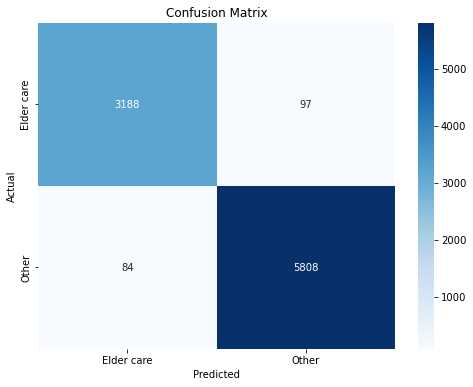

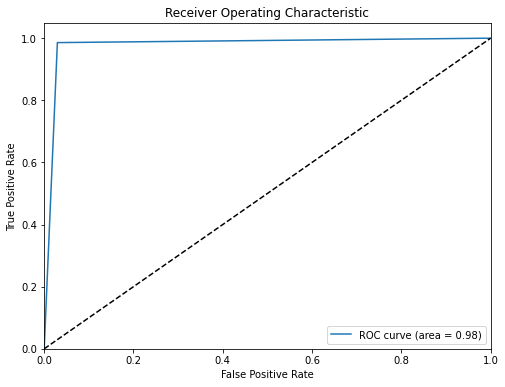

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Step 15: Generate the confusion matrix
cm = confusion_matrix(test_labels, predictions)
label_names = ['Elder care', 'Other']

# Convert labels to numerical values
test_labels_numeric = np.where(np.array(test_labels) == 'Elder care', 0, 1)
predictions_numeric = np.where(np.array(predictions) == 'Elder care', 0, 1)

# Calculate additional metrics
classification_metrics = classification_report(test_labels_numeric, predictions_numeric, target_names=label_names, output_dict=True)
fpr, tpr, thresholds = roc_curve(test_labels_numeric, predictions_numeric)
auc_score = roc_auc_score(test_labels_numeric, predictions_numeric)

# Print classification report
print("Classification Report:")
for label in label_names:
    print(f"Label: {label}")
    print(f"  Precision: {classification_metrics[label]['precision']}")
    print(f"  Recall: {classification_metrics[label]['recall']}")
    print(f"  F1-Score: {classification_metrics[label]['f1-score']}")
    print(f"  Support: {classification_metrics[label]['support']}")

# Print additional metrics
print("F1 Score:", classification_metrics['weighted avg']['f1-score'])
print("Accuracy:", classification_metrics['accuracy'])
print("Precision:", classification_metrics['weighted avg']['precision'])
print("Recall:", classification_metrics['weighted avg']['recall'])
print("AUC:", auc_score)

# Step 16: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [32]:
test_labels[:1], yhat[:,1]

(array(['Elder care'], dtype=object),
 array([0.05202558, 0.99871416, 0.00108227, ..., 0.99794701, 0.98057486,
        0.99137941]))

In [34]:
 best_model.predict(test_encodings)

array(['Elder care', 'Other', 'Elder care', ..., 'Other', 'Other',
       'Other'], dtype=object)

In [33]:
yhat

array([[0.94797442, 0.05202558],
       [0.00128584, 0.99871416],
       [0.99891773, 0.00108227],
       ...,
       [0.00205299, 0.99794701],
       [0.01942514, 0.98057486],
       [0.00862059, 0.99137941]])

In [37]:
test_labels_replaced = np.where(test_labels == 'Elder care', 1, 0)
test_labels_replaced

array([1, 0, 1, ..., 0, 0, 0])

In [38]:
# imporiving threshold for f1
# best_model = 'Bert_EC_model/ec_model_v1.pkl'
from sklearn.metrics import f1_score

best_model = joblib.load('Bert_EC_model/ec_model_v1.pkl')
test_encodings = model.encode(test_texts)

thresholds = np.arange(0, 1, 0.001)
yhat = best_model.predict_proba(test_encodings)
scores = [f1_score(test_labels_replaced, (yhat[:, 0] >= t).astype('int'), average='macro') for t in thresholds]
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.485, F-Score=0.97913


# prediction: 

### loading data for prediction

In [40]:
import time
start_time = time.time()

In [41]:
import spacy
import en_core_web_sm
import re
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

from sentence_transformers import SentenceTransformer

nlp = spacy.load("en_core_web_sm")

import boto3
import pandas as pd
import pyarrow.parquet as pq
import s3fs
import joblib

import string
import nltk
nltk.data.path.append('../../nltk_data')
from nltk.corpus import stopwords
# nltk.download('stopwords')

# Initialize S3 client
s3 = boto3.client('s3')

# Specify the S3 bucket and prefix where the Parquet files are stored
# s3://adl-core-sagemaker-studio/external/IVA/IVA_daily/
# s3://adl-core-sagemaker-studio/external/IVA/Search_daily/
# s3://adl-core-sagemaker-studio/external/Deepali/iva-data(3-apr).csv
bucket_name = 'adl-core-sagemaker-studio'
# prefix = 'external/web_clickstream/clickstream20230403_20230403/'
prefix = 'external/Deepali/search_data/'

# List all Parquet files in the bucket with the specified prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
if 'Contents' in response:
    # parquet_files = [obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.parq')]
    csv_files = [obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.csv')]
else:
    # parquet_files = []
    csv_files = []

# Read Parquet files and concatenate them together
dfs = []
s3fs = s3fs.S3FileSystem()

# for file in parquet_files:
for file in csv_files:
    # Read the Parquet file into a PyArrow table
    s3_key = f"{bucket_name}/{file}"
    # dataset = pq.ParquetDataset(f"s3://{s3_key}", filesystem=s3fs)
    df = pd.read_csv(f"s3://{s3_key}")
    # table = dataset.read()
    
    # Convert the PyArrow table to a Pandas DataFrame
    # df = table.to_pandas()
    dfs.append(df)

# Concatenate all the DataFrames together
if dfs:
    concatenated_df = pd.concat(dfs, ignore_index=True)
    print(concatenated_df.head())
else:
    # print("No Parquet files found.")
    print("No csv files found.")

   person_internal_id  client_id  platform_id  \
0           124300026       7538         7538   
1            73810075       1995         1995   
2           382000024       2360         2360   
3           411840023       2346         2346   
4           356000078       2360         2360   

                         search_text  search_results  
0                         My Billing               7  
1                     Employee Stock              32  
2                          1095 Form              84  
3                         reed group             146  
4  macys cash account reirement fund             155  


In [42]:
concatenated_df.shape

(11813, 5)

In [43]:
words_3 = ['elder','elder women','elder','Octogenarians','Nonagenarians','Centenarians',
'elderly people',
 'senior assistance',
 'grey generation',
 'senior health',
 'elderly companion',
 'senior citizen',
 'elderly',
 'senior members',
 'elderly residents',
 'senior assistance',
 'grey generation',
 'elder',
 'elderly',
 'elderly people',
 'elderly residents',
 'elder',
 'elder',
 'senior citizen',
 'elder generation',
 'gerontology',
 'elderly population',
 'senior members',
 'retirees',
 'elderly population',
 'eldercare',
 'elder',
'eldercae', 'eldercarr', 'eldermann',
'eldercre','eldery','elderman','elders','eldercrae']

words_4 = set([word.lower() for word in words_3])

len(words_4)


27

In [44]:
# def check_phrases(row, col='input'):
#     if any(phrase in col for phrase in words_4):
#         return 'Yes'
#     return 'No'

# # Apply the function to create a new column
# concatenated_df['Contains_syn'] = concatenated_df.apply(check_phrases, axis=1)

In [45]:
concatenated_df.head()

person_internal_id  client_id  platform_id  \
0           124300026       7538         7538   
1            73810075       1995         1995   
2           382000024       2360         2360   
3           411840023       2346         2346   
4           356000078       2360         2360   

                         search_text  search_results  
0                         My Billing               7  
1                     Employee Stock              32  
2                          1095 Form              84  
3                         reed group             146  
4  macys cash account reirement fund             155

In [46]:

def clean_text(df, text_cols):
    # Create a new dataframe to hold the cleaned text columns
    cleaned_df = pd.DataFrame()
    
    # Define the list of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Clean each text column and add it to the cleaned dataframe
    for text_col in text_cols:
        text_list = df[text_col].tolist()
        text_list = [str(text) for text in text_list]
        text_list = [text if text.strip() and not
                     set(text).issubset(set(string.punctuation + string.whitespace)) else '' 
                     for text in text_list]
        text_list = [x.lower() for x in text_list]
        translator = str.maketrans(string.punctuation + string.digits + "_", " " * len(
            string.punctuation + string.digits + "_"))
        cleaned_list = []
        for text in text_list:
            cleaned_text = text.translate(translator)
            cleaned_text = ' '.join(cleaned_text.split())
            cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stop_words])
            cleaned_list.append(cleaned_text)
        cleaned_df[text_col] = cleaned_list
    
    # Add the non-text columns to the cleaned dataframe
    for col in df.columns:
        if col not in text_cols:
            cleaned_df[col] = df[col]
    
    return cleaned_df


In [47]:
# concatenated_df.columns

In [48]:
# concatenated_df= concatenated_df[['client_id','person_internal_id','page_name']]
concatenated_df= concatenated_df[['client_id','person_internal_id','search_text']]

In [49]:
# concatenated_df.head()

In [50]:
concatenated_df.shape

(11813, 3)

In [57]:
# cleaned_concatenated_df = clean_text(concatenated_df, text_cols=['page_name'])
cleaned_concatenated_df = clean_text(concatenated_df, text_cols=['search_text'])

In [58]:
cleaned_concatenated_df.head()

search_text  client_id  person_internal_id
0                            billing       7538           124300026
1                     employee stock       1995            73810075
2                               form       2360           382000024
3                         reed group       2346           411840023
4  macys cash account reirement fund       2360           356000078

In [59]:
# text_preprocessed_cleaned_concatenated_df = text_preprocess(cleaned_concatenated_df, col='reportingfields_fieldvalue1' )

In [60]:
# Final prediction code 

In [61]:
# # Step 10: Load the model


# loaded_model = joblib.load('Bert_EC_model/ec_model_v1.pkl')
# model = SentenceTransformer('all-mpnet-base-v2')

# # Step 12: Encode the text samples from the Parquet file
# encodings = model.encode(cleaned_concatenated_df['search_text'].fillna(' ').tolist())

# # Step 13: Make predictions for the encoded samples
# cleaned_concatenated_df['prediction'] = loaded_model.predict(encodings)
# # text_preprocessed_cleaned_concatenated_df['confidence_level'] = np.max(loaded_model.predict_proba(encodings), axis=1)

# # Step 14: Save the predictions in an Excel file
# cleaned_concatenated_df.to_excel('ec_search_3april_predictions.xlsx', index=False)

# elapsed_time = time.time() - start_time
# print(elapsed_time)

In [62]:
# import numpy as np
# import pandas as pd
# from sklearn.externals import joblib
# from sentence_transformers import SentenceTransformer

# Load the model
loaded_model = joblib.load('Bert_EC_model/ec_model_v1.pkl')
model = SentenceTransformer('all-mpnet-base-v2')

# Encode the text samples from the Parquet file
encodings = model.encode(cleaned_concatenated_df['search_text'].fillna(' ').tolist())

# Make predictions for the encoded samples
# predictions = loaded_model.predict(encodings)
probabilities = loaded_model.predict_proba(encodings)
threshold = 0.485 #for EC

# Apply threshold and assign labels
cleaned_concatenated_df['prediction'] = np.where(probabilities[:, 0] > threshold, 'Elder care', 'Other')

# Save the predictions in an Excel file
cleaned_concatenated_df.to_excel('ec_search_3april_predictions_v1.xlsx', index=False)

elapsed_time = time.time() - start_time
print(elapsed_time)


151.84863662719727


--------------------

In [ ]:
import time
start_time = time.time()

import spacy
import en_core_web_sm

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

nlp = spacy.load("en_core_web_sm")

In [20]:
import boto3
import pyarrow.parquet as pq
import s3fs

# Initialize S3 client
s3 = boto3.client('s3')

# Specify the S3 bucket and prefix where the Parquet files are stored
bucket_name = 'adl-core-sagemaker-studio'
prefix = 'external/web_clickstream/clickstream20230403_20230403/'

# List all Parquet files in the bucket with the specified prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
if 'Contents' in response:
    parquet_files = [obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.parq')]
else:
    parquet_files = []

# Read Parquet files and concatenate them together
dfs = []
s3fs = s3fs.S3FileSystem()

for file in parquet_files:
    # Read the Parquet file into a PyArrow table
    s3_key = f"{bucket_name}/{file}"
    dataset = pq.ParquetDataset(f"s3://{s3_key}", filesystem=s3fs)
    table = dataset.read()
    
    # Convert the PyArrow table to a Pandas DataFrame
    df = table.to_pandas()
    dfs.append(df)

# Concatenate all the DataFrames together
if dfs:
    concatenated_df = pd.concat(dfs, ignore_index=True)
    print(concatenated_df.head())
else:
    print("No Parquet files found.")

                           web_page_detail_event_key  \
0  b'-78rg69zVADh2W1BGlZ_nAg_1487#2023-04-03 11:1...   
1  b'-78rg69zVADh2W1BGlZ_nAg_1487#2023-04-03 11:1...   
2  b'-78rg69zVADh2W1BGlZ_nAg_1487#2023-04-03 11:1...   
3  b'-78rg69zVADh2W1BGlZ_nAg_1487#2023-04-03 11:1...   
4  b'-78rg69zVADh2W1BGlZ_nAg_1487#2023-04-03 11:1...   

                   web_page_detail_event_key_columns client_key  \
0  b'web_session_id#session_create_timestamp_cst_...   b'11487'   
1  b'web_session_id#session_create_timestamp_cst_...   b'11487'   
2  b'web_session_id#session_create_timestamp_cst_...   b'11487'   
3  b'web_session_id#session_create_timestamp_cst_...   b'11487'   
4  b'web_session_id#session_create_timestamp_cst_...   b'11487'   

                                  implementation_key  platform_id  client_id  \
0  b'148714873jxgemzn5qhzvwzg1avc42clfkdt05vcylcn...         1487       1487   
1  b'148714873jxgemzn5qhzvwzg1avc42clfkdt05vcylcn...         1487       1487   
2  b'148714873jxgemz

In [21]:
concatenated_df= concatenated_df[['client_id','person_internal_id','page_name']]

In [22]:
import string
import nltk
nltk.data.path.append('../../nltk_data')
from nltk.corpus import stopwords
# nltk.download('stopwords')


In [23]:
def clean_text(df, text_cols):
    # Create a new dataframe to hold the cleaned text columns
    cleaned_df = pd.DataFrame()
    
    # Define the list of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Clean each text column and add it to the cleaned dataframe
    for text_col in text_cols:
        text_list = df[text_col].tolist()
        text_list = [str(text) for text in text_list]
        text_list = [text if text.strip() and not
                     set(text).issubset(set(string.punctuation + string.whitespace)) else '' 
                     for text in text_list]
        text_list = [x.lower() for x in text_list]
        translator = str.maketrans(string.punctuation + string.digits + "_", " " * len(
            string.punctuation + string.digits + "_"))
        cleaned_list = []
        for text in text_list:
            cleaned_text = text.translate(translator)
            cleaned_text = ' '.join(cleaned_text.split())
            cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stop_words])
            cleaned_list.append(cleaned_text)
        cleaned_df[text_col] = cleaned_list
    
    # Add the non-text columns to the cleaned dataframe
    for col in df.columns:
        if col not in text_cols:
            cleaned_df[col] = df[col]
    
    return cleaned_df


In [24]:
cleaned_concatenated_df = clean_text(concatenated_df, text_cols=['page_name'])

In [25]:
import re
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from functools import partial

def count_intnt_entits(doc):
    intents = [token.text for token in doc if token.pos_ == 'VERB']
    entities = [token.text for token in doc if token.pos_ in {'NOUN', 'PROPN', 'ADJ', 'NUM', 'ADV'}]
    return len(intents), len(entities)

def extract_ner_entities(doc, sentence):
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

def length_entities(list_entities):
    if (list_entities == np.nan or list_entities is None or list_entities == ''):
        return 0
    else:
        return len(list_entities)

def filter_named_entities(doc, text):
    filtered_words = [token.text for token in doc if token.ent_type_ not in ['ORG', 'PERSON', 'GPE', 'LOC', 'FAC']]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

def process_text(text):
    doc = nlp(text)
    intents, entities = count_intnt_entits(doc)
    ner_entities = extract_ner_entities(doc, text)
    len_ner_entities = length_entities(ner_entities)
    filtered_text = filter_named_entities(doc, text)
    return intents, entities, ner_entities, len_ner_entities, filtered_text

def text_preprocess(dataframe, col='page_name'):
    dataframe = dataframe.drop_duplicates()
    texts = dataframe[col].tolist()
    # texts = dataframe['text'].tolist()
    with ProcessPoolExecutor(max_workers=96) as executor:
        processed_results = list(executor.map(process_text, texts))

    intents, entities, ner_entities, len_ner_entities, filtered_texts = zip(*processed_results)
    
    dataframe['no_of_intents'] = intents
    dataframe['no_of_entities'] = entities
    dataframe['ner_enities'] = ner_entities
    dataframe['len_ner_enities'] = len_ner_entities
    dataframe[col]= filtered_texts
    
    dataframe = dataframe[dataframe['len_ner_enities'] > 0]
    dataframe[col] = dataframe[col].str.strip()
    dataframe = dataframe.drop(['no_of_intents', 'no_of_entities', 'ner_enities', 'len_ner_enities'], axis=1)
    
    return dataframe


In [26]:
text_preprocessed_cleaned_concatenated_df = text_preprocess(cleaned_concatenated_df, col='page_name' )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [28]:
# Step 10: Load the model
import joblib
loaded_model = joblib.load('Bert_EC_model/ec_model.pkl')
model = SentenceTransformer('all-mpnet-base-v2')

# Step 12: Encode the text samples from the Parquet file
encodings = model.encode(text_preprocessed_cleaned_concatenated_df['page_name'].fillna(' ').tolist())

# Step 13: Make predictions for the encoded samples
text_preprocessed_cleaned_concatenated_df['prediction'] = loaded_model.predict(encodings)
# text_preprocessed_cleaned_concatenated_df['confidence_level'] = np.max(loaded_model.predict_proba(encodings), axis=1)

# Step 14: Save the predictions in an Excel file
text_preprocessed_cleaned_concatenated_df.to_excel('ec_3april_web_predictions.xlsx', index=False)

elapsed_time = time.time() - start_time
print(elapsed_time)

2223.426661968231


In [693]:
import time
start_time = time.time()

# Step 10: Load the model
loaded_model = joblib.load('Bert_EC_model/ec_model.pkl')

# Step 11: Read data from Parquet file
# data = pd.read_csv('query-impala-160880_search_3_4April.csv')[['reportingfields_fieldvalue1']]
data = pd.read_parquet('clickstream20230406_2023040620230406_20230406.10.parq')['page_name']
data.head()

0       b'CSERR200DFLTCRTCOPEN'
1    b'CSLOGN020ENTRPRSNIDOPEN'
2    b'CSLOGN020ENTRPRSNIDOPEN'
3          b'CSLOGN010INPTOPEN'
4       b'CSERR200DFLTCRTCOPEN'
Name: business_page_name, dtype: object

In [687]:
data.shape

(20262, 1)

In [689]:
# Step 12: Encode the text samples from the Parquet file
encodings = model.encode(data['reportingfields_fieldvalue1'].fillna(' ').tolist())

# Step 13: Make predictions for the encoded samples
data['prediction'] = loaded_model.predict(encodings)

# Step 14: Save the predictions in an Excel file
data.to_excel('search_query-impala-160880_search_3_4April_ec_predictions.xlsx', index=False)

elapsed_time = time.time() - start_time
print(elapsed_time)

56.63199019432068


In [662]:
# list_of_texts = ["senior-citizen?care expense reimbursement", 
#                  "elderly*care plus",
#                  "aging care home", "retirees care reimbirsement", 
#                  "senior assistance required","Daycare@expense reimbursement",
#                  "baby care licensed", "oldsters care home","geriatric care home",
#                  "contentPage 2023 Eldercare!!!!!!!!!!!!!****@_Subsidy","Elder statesmen care",
#                  "Elder women care","Silver generation care",
#                  "contentPage {}[]/\|?><,.;:!@#+\t\n\r\f\v 2023 Elder care Subsidy","gerontology care",
#                  "Elderly Care Plus Information"]


### convert saved model .bin and config.json to .pkl compatible files

In [ ]:
# convert saved model .bin and config.json to .pkl compatible files
from transformers import AutoConfig, AutoModelForSequenceClassification
import torch
import pickle

# Load the model configuration from the config.json file
config = AutoConfig.from_pretrained('EC_model_outer_combined_texts_data_v6', num_labels=2)

# Load the model from the binary file using the configuration
model = AutoModelForSequenceClassification.from_pretrained('EC_model_outer_combined_texts_data_v6', config=config)

# Save the model and configuration as a pickle file
with open('EC_model_outer_combined_texts_data_v6/EC_model.pkl', 'wb') as f:
    pickle.dump((config, model.state_dict()), f)

## tagging the unseen_data for analysisng the predictions

### finding the texts which contain exact phrases from synonyms list

In [41]:
words_3 = ['older parent','older people','grand parents','elder','old parents','elder women',
 'silver generation','aged people', 'older women','older men','old age home','elder',
 'aged',
 'elderly people',
 'senior assistance',
 'aging-in-place',
 'aged population',
 'golden agers',
 'aging in place',
 'grey generation',
 'silver generation',
 'senior health',
 'aged population',
 'elderly companion',
 'golden agers',
 'senior citizen',
 'elder support',
 'elderly',
 'senior members',
 'elder population',
 'elderly residents',
 'senior assistance',
 'oldsters',
 'grey generation',
 'aging population',
 'elder statesmen',
 'elderly',
 'elderly people',
 'aging',
 'elderly residents',
 'elder',
 'elder women',
 'senior',
 'elder generation',
 'gerontology',
 'elderly population',
 'senior members',
 'retirees',
 'elderly population',
 'eldercare',
 'geriatric',
 'elder statesmen',
 'age related',
 'retirees',
 'third age population',
 'aging population',
 'elder population',
 'oldsters',
 'third age population','eldercae', 'eldercarr', 'eldermann', 
'aged home','eldercre','eldery','elderman','elders','eldercrae',]
words_4 = list(set([word.lower() for word in words_3]))
len(words_4)

49

In [42]:
df_cleaned = pd.DataFrame()
df_cleaned['text'] =cleaned_text_list
df_cleaned.head(5)

text
0    welcomeuserfollowup
1    medical plan credit
2            welcomeuser
3  general purpose loans
4    chiropractor visits

In [43]:
mask = (df_cleaned['text'].str.contains(r'\b(' + '|'.join(words_4) + r')\b', case=False, na=False))

df_cleaned['category'] = ''
df_cleaned.loc[mask, 'category'] = 'Elder care'
# df_combined_web_iva_search.loc[df_combined_web_iva_search['category'] == '', 'category'] = 'Other'

df_cleaned.head(5)

/tmp/ipykernel_74027/3427755096.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = (df_cleaned['text'].str.contains(r'\b(' + '|'.join(words_4) + r')\b', case=False, na=False))


text category
0    welcomeuserfollowup         
1    medical plan credit         
2            welcomeuser         
3  general purpose loans         
4    chiropractor visits

In [45]:
df_cleaned[df_cleaned['category']=='Elder care'].sample(1)

text    category
5666  ongoing elderly care  Elder care

In [46]:
df_cleaned[df_cleaned['category']=='Elder care'].shape

(13, 2)

### get text which are similar to phrases in synonnyms list for texts other than which are filtered above

In [50]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [51]:
def find_similar_sentences(df, sentences, phrases, threshold=0.95, category_name = 'Elder care'):
    # encode the phrases using the model
    phrase_embeddings = model.encode(phrases, convert_to_tensor=True)
    
    # initialize an empty list to store the similar sentences
    similar_sentences = []
    
    # iterate over the sentences
    for sentence in sentences:
        # encode the sentence using the model
        sentence_embedding = model.encode(sentence, convert_to_tensor=True)
        # reshape the sentence embedding to a 2D array
        sentence_embedding = sentence_embedding.reshape(1, -1)
        
        # calculate the cosine similarity between the sentence embedding and each phrase embedding
        cosine_scores = 1 - cosine_distances(sentence_embedding, phrase_embeddings)
        
        # convert the cosine similarity scores to a list
        scores_list = cosine_scores.tolist()[0]
        
        # iterate over the phrases and similarity scores and append the sentence to the list if it meets the threshold for at least one phrase
        for phrase, score in zip(phrases, scores_list):
            if score >= threshold:
                similar_sentences.append(sentence)
                break
    
    # convert the list of similar sentences to a set to remove duplicates
    similar_sentences = set(similar_sentences)
    
    # create a new dataframe containing only the rows with text that is in the set of similar sentences
    similar_df = df[df['text'].isin(similar_sentences)]
    similar_df['category']=category_name
    return similar_df

In [52]:
similar_df_unseen = find_similar_sentences(df_cleaned, 
                                    df_cleaned[df_cleaned['category']=='']['text'].to_list(), 
                                    words_4)

/tmp/ipykernel_74027/2749835889.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_df['category']=category_name


In [53]:
similar_df_unseen

text    category
7095  retiremen  Elder care

In [54]:
unseen_EC_df = pd.concat([df_cleaned[df_cleaned['category']=='Elder care'], 
                       similar_df_unseen]).sample(frac=1)

In [55]:
unseen_EC_df.shape

(14, 2)

In [56]:
unseen_EC_df.drop_duplicates(inplace=True)

In [57]:
unseen_EC_df.shape

(14, 2)

In [58]:
# filter out the rows with similar text from the original DataFrame
non_similar_unseen_df = df_cleaned[~df_cleaned['text'].isin(unseen_EC_df['text'])]

# sample twice as many rows from the non-similar DataFrame as there are in the similar DataFrame
# non_similar_df = non_similar_df.sample(n=only_EC_df.shape[0]*2)
non_similar_unseen_df['category'] = 'Other'

/tmp/ipykernel_74027/3802977147.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_similar_unseen_df['category'] = 'Other'


In [59]:
df_unseen_concatenated = pd.concat([unseen_EC_df, non_similar_unseen_df]).sample(frac=1).reset_index(drop=True)
# df_concatenated = df_concatenated
# df_concatenated.drop(columns=['input', 'search_text', 'page_name'], inplace=True)

In [60]:
pd.set_option('display.max_colwidth', None)

In [61]:
df_unseen_concatenated.shape

(12584, 2)

In [62]:
df_unseen_concatenated[(df_unseen_concatenated.text.str.contains('elder')) & (df_unseen_concatenated.category=='Other')]

Empty DataFrame
Columns: [text, category]
Index: []

In [63]:
pd.reset_option('display.max_colwidth')

In [64]:
df_unseen_concatenated.to_excel('labelled_unseen_data.xlsx')